In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

In [3]:
batch_size = 128
z_dim = 100

In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset.MNIST('mnist', train = True, download = True, transform = transform),
    batch_size = batch_size,
    shuffle = True
)

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class Generator_model(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc = nn.Linear(z_dim, 256 * 7 * 7)
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 256, 7, 7)
        return self.gen(x)

In [8]:
generator = Generator_model(z_dim).to(device)

In [9]:
generator.apply(weights_init)

Generator_model(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (gen): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

In [10]:
summary(generator, (100, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,266,944
   ConvTranspose2d-2          [-1, 128, 14, 14]         524,416
       BatchNorm2d-3          [-1, 128, 14, 14]             256
         LeakyReLU-4          [-1, 128, 14, 14]               0
   ConvTranspose2d-5           [-1, 64, 14, 14]          73,792
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]           1,025
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 1,866,561
Trainable params: 1,866,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.97
Params size (MB): 7.12
Estimated Total Size (MB): 8.09
---------------------------------------

In [11]:
class Discriminator_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01)
        )
        self.fc = nn.Linear(2048, 1)
    def forward(self, input):
        x = self.disc(input)
        return F.sigmoid(self.fc(x.view(-1, 2048)))

In [12]:
discriminator = Discriminator_model().to(device)

In [13]:
discriminator.apply(weights_init)

Discriminator_model(
  (disc): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [14]:
summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
       BatchNorm2d-4             [-1, 64, 7, 7]             128
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Conv2d-6            [-1, 128, 4, 4]          73,856
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Linear-9                    [-1, 1]           2,049
Total params: 95,105
Trainable params: 95,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.36
Estimated Total Size (MB): 0.58
---------------------------------------------

/home/jibin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
criterion = nn.BCELoss()

In [16]:
fixed_noise = torch.randn(64, z_dim, device=device)

In [17]:
doptimizer = optim.Adam(discriminator.parameters())
goptimizer = optim.Adam(generator.parameters())

In [18]:
real_label, fake_label = 1, 0

In [19]:
image_list = []
g_losses = []
d_losses = []
iterations = 0
num_epochs = 50

In [20]:
for epoch in range(num_epochs):
    print(f'Epoch : | {epoch+1:03} / {num_epochs:03} |')
    for i, data in enumerate(train_loader):
        
        discriminator.zero_grad()
        
        real_images = data[0].to(device)
        size = real_images.size(0)
        label = torch.full((size,), real_label, device=device)
        d_output = discriminator(real_images).view(-1)
        derror_real = criterion(d_output, label)
        derror_real.backward()
        
        noise = torch.randn(size, z_dim, device=device)
        fake_images = generator(noise)
        label.fill_(0)
        d_output = discriminator(fake_images.detach()).view(-1)
        derror_fake = criterion(d_output, label)
        derror_fake.backward()
        
        derror_total = derror_real + derror_fake
        doptimizer.step()
        
        generator.zero_grad()
        label.fill_(real_images)
        d_output = discriminator(fake_images).view(-1)
        gerror = criterion(d_output, label)
        gerror.backward()
        
        goptimizer.step()
        
        if i % 50 == 0:
            print(f'| {i:03} / {len(train_loader):03} | G Loss: {gerror.item():.3f} | D Loss: {derror_total.item():.3f} |')
            g_losses.append(gerror.item())
            d_losses.append(derror_total.item())
            
        if (iterations % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake_images = generator(fixed_noise).detach().cpu()
            image_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
            
        iterations += 1

Epoch : | 001 / 050 |


/home/jibin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


| 000 / 469 | G Loss: 1.939 | D Loss: 1.432 |
| 050 / 469 | G Loss: 3.920 | D Loss: 0.266 |
| 100 / 469 | G Loss: 3.900 | D Loss: 0.406 |
| 150 / 469 | G Loss: 3.260 | D Loss: 0.230 |
| 200 / 469 | G Loss: 3.856 | D Loss: 0.556 |
| 250 / 469 | G Loss: 4.097 | D Loss: 0.123 |
| 300 / 469 | G Loss: 2.377 | D Loss: 0.416 |
| 350 / 469 | G Loss: 2.984 | D Loss: 0.416 |
| 400 / 469 | G Loss: 3.262 | D Loss: 0.140 |
| 450 / 469 | G Loss: 3.469 | D Loss: 0.849 |
Epoch : | 002 / 050 |
| 000 / 469 | G Loss: 2.057 | D Loss: 0.484 |
| 050 / 469 | G Loss: 2.108 | D Loss: 0.435 |
| 100 / 469 | G Loss: 1.714 | D Loss: 0.862 |
| 150 / 469 | G Loss: 3.902 | D Loss: 0.199 |
| 200 / 469 | G Loss: 3.869 | D Loss: 0.086 |
| 250 / 469 | G Loss: 2.390 | D Loss: 0.208 |
| 300 / 469 | G Loss: 3.008 | D Loss: 0.586 |
| 350 / 469 | G Loss: 4.662 | D Loss: 0.074 |
| 400 / 469 | G Loss: 3.353 | D Loss: 0.368 |
| 450 / 469 | G Loss: 5.080 | D Loss: 0.110 |
Epoch : | 003 / 050 |
| 000 / 469 | G Loss: 7.159 | D Loss

| 050 / 469 | G Loss: 5.536 | D Loss: 0.183 |
| 100 / 469 | G Loss: 3.011 | D Loss: 0.195 |
| 150 / 469 | G Loss: 5.292 | D Loss: 0.063 |
| 200 / 469 | G Loss: 4.090 | D Loss: 0.183 |
| 250 / 469 | G Loss: 4.319 | D Loss: 0.674 |
| 300 / 469 | G Loss: 4.685 | D Loss: 0.102 |
| 350 / 469 | G Loss: 3.380 | D Loss: 0.343 |
| 400 / 469 | G Loss: 2.504 | D Loss: 0.234 |
| 450 / 469 | G Loss: 1.100 | D Loss: 0.237 |
Epoch : | 019 / 050 |
| 000 / 469 | G Loss: 3.946 | D Loss: 0.244 |
| 050 / 469 | G Loss: 4.332 | D Loss: 0.093 |
| 100 / 469 | G Loss: 4.761 | D Loss: 0.073 |
| 150 / 469 | G Loss: 2.069 | D Loss: 0.168 |
| 200 / 469 | G Loss: 4.493 | D Loss: 0.103 |
| 250 / 469 | G Loss: 4.828 | D Loss: 0.090 |
| 300 / 469 | G Loss: 3.787 | D Loss: 0.128 |
| 350 / 469 | G Loss: 6.053 | D Loss: 0.116 |
| 400 / 469 | G Loss: 3.745 | D Loss: 0.147 |
| 450 / 469 | G Loss: 3.565 | D Loss: 0.129 |
Epoch : | 020 / 050 |
| 000 / 469 | G Loss: 3.070 | D Loss: 0.146 |
| 050 / 469 | G Loss: 2.750 | D Loss

| 050 / 469 | G Loss: 4.693 | D Loss: 0.112 |
| 100 / 469 | G Loss: 5.053 | D Loss: 0.034 |
| 150 / 469 | G Loss: 4.853 | D Loss: 0.127 |
| 200 / 469 | G Loss: 4.905 | D Loss: 0.189 |
| 250 / 469 | G Loss: 2.615 | D Loss: 0.131 |
| 300 / 469 | G Loss: 2.153 | D Loss: 1.731 |
| 350 / 469 | G Loss: 6.211 | D Loss: 0.493 |
| 400 / 469 | G Loss: 5.485 | D Loss: 0.026 |
| 450 / 469 | G Loss: 1.012 | D Loss: 0.057 |
Epoch : | 036 / 050 |
| 000 / 469 | G Loss: 3.083 | D Loss: 0.143 |
| 050 / 469 | G Loss: 4.324 | D Loss: 0.175 |
| 100 / 469 | G Loss: 4.538 | D Loss: 0.145 |
| 150 / 469 | G Loss: 6.720 | D Loss: 0.149 |
| 200 / 469 | G Loss: 4.259 | D Loss: 0.086 |
| 250 / 469 | G Loss: 5.626 | D Loss: 0.065 |
| 300 / 469 | G Loss: 7.494 | D Loss: 0.398 |
| 350 / 469 | G Loss: 4.209 | D Loss: 0.053 |
| 400 / 469 | G Loss: 5.236 | D Loss: 0.038 |
| 450 / 469 | G Loss: 5.366 | D Loss: 0.105 |
Epoch : | 037 / 050 |
| 000 / 469 | G Loss: 3.863 | D Loss: 0.028 |
| 050 / 469 | G Loss: 5.976 | D Loss

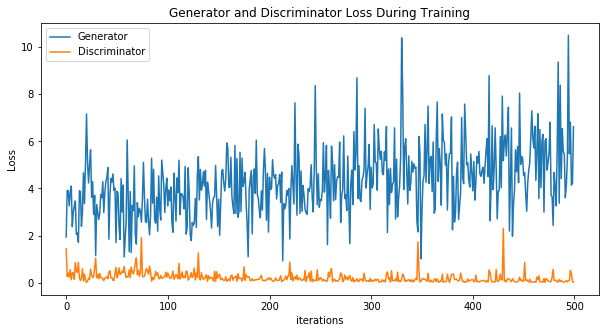

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

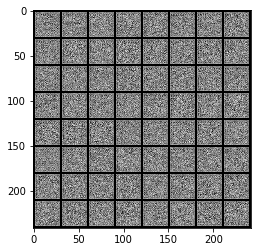

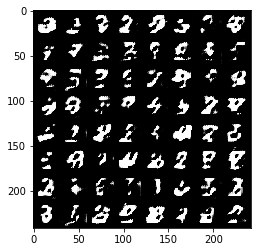

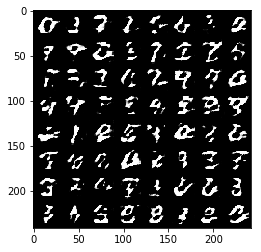

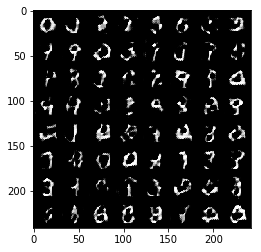

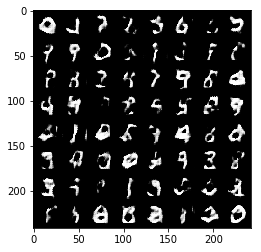

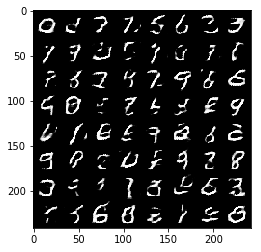

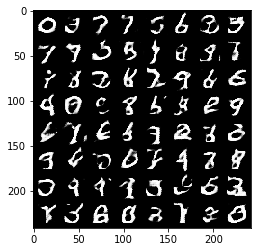

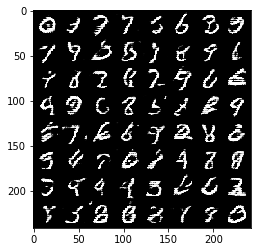

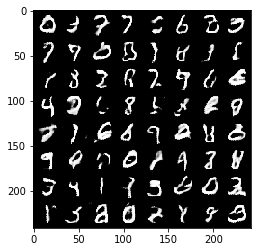

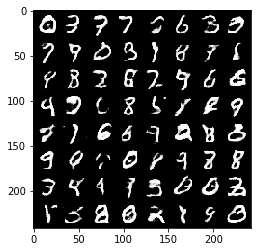

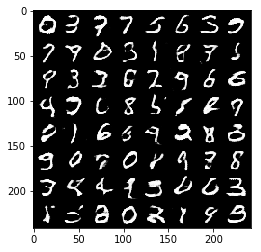

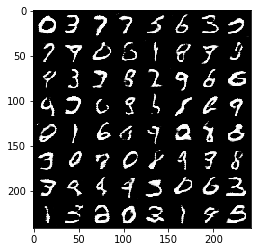

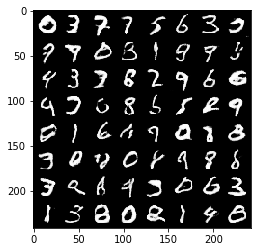

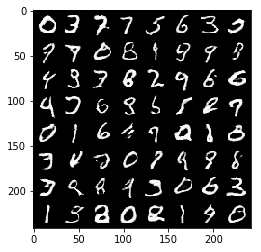

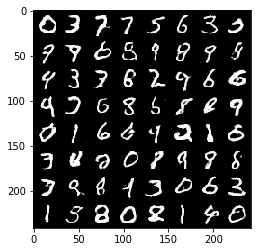

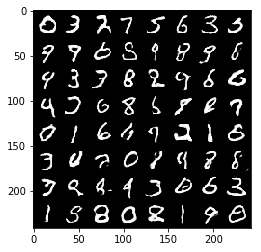

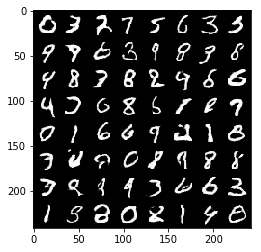

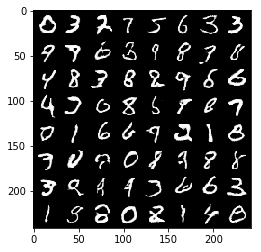

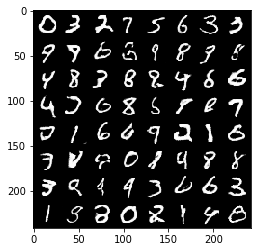

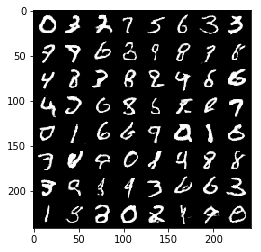

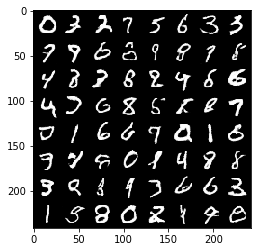

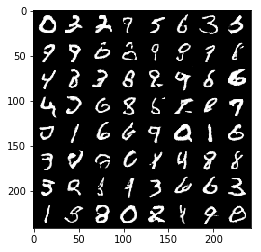

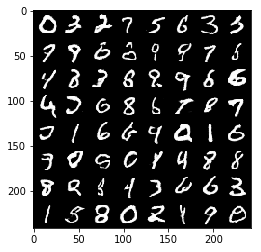

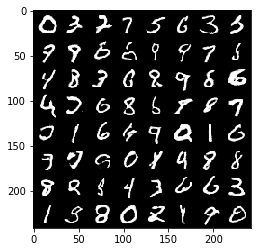

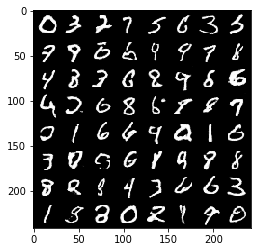

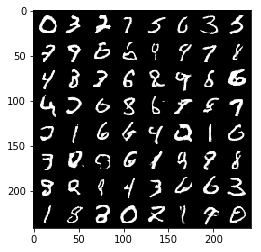

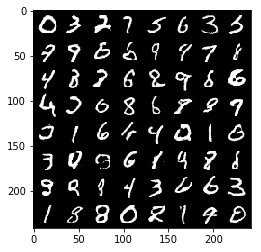

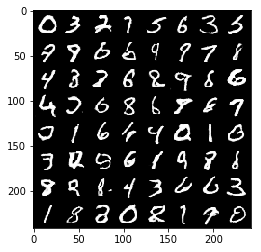

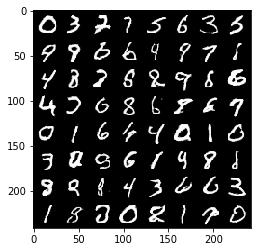

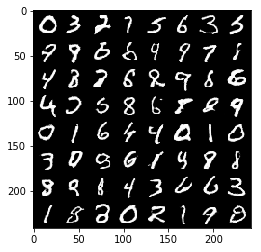

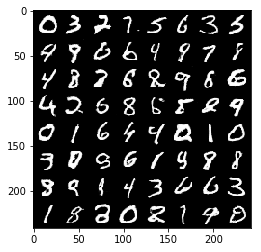

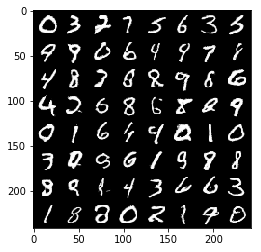

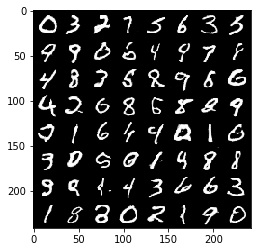

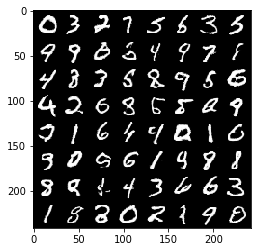

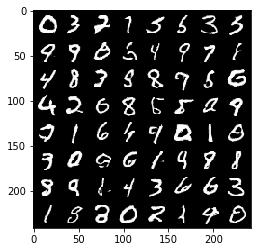

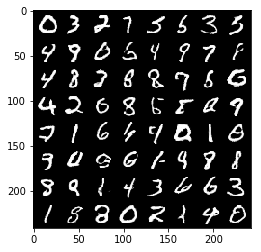

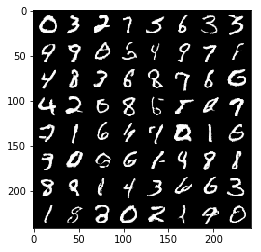

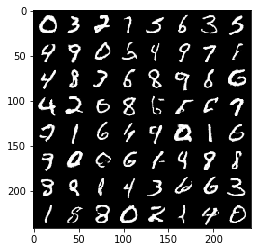

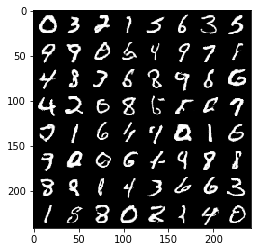

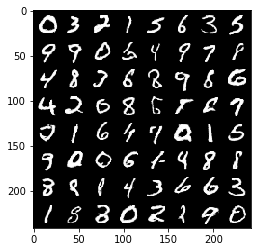

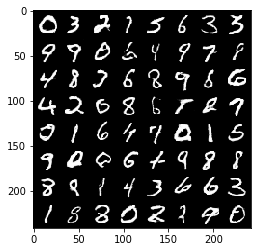

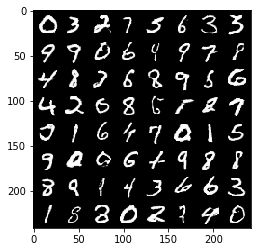

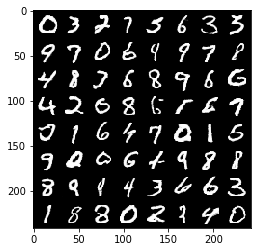

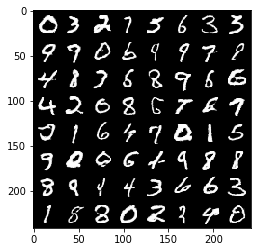

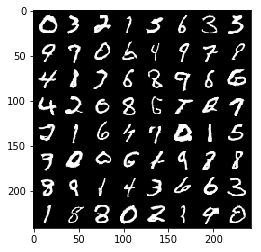

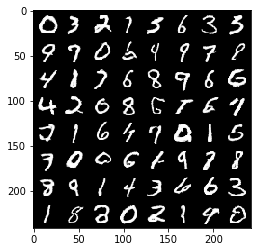

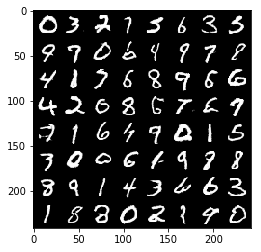

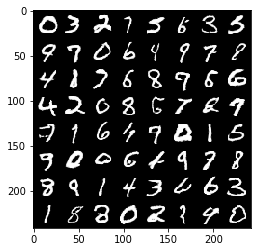

In [27]:
for image in image_list:
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()